In [1]:
import tensorflow as tf

tf.reset_default_graph()

saver = tf.train.import_meta_graph("models/car_cnn.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("x:0")

logits= tf.get_default_graph().get_tensor_by_name("output/BiasAdd:0")

index=tf.argmax(tf.nn.softmax(logits),1)
conf=tf.nn.softmax(logits)
sess= tf.Session()
saver.restore(sess, "models/car_cnn.ckpt")

INFO:tensorflow:Restoring parameters from models/car_cnn.ckpt


detection location 30 30
detection location 40 30


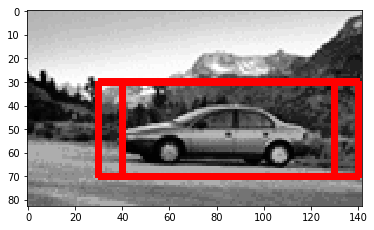

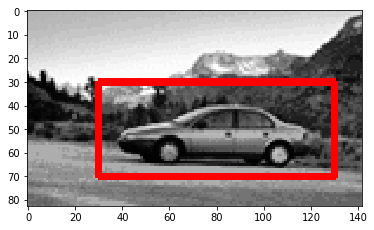

In [2]:
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.feature import hog
from sklearn.externals import joblib 
import cv2
import matplotlib.pyplot as plt
from mns import nms,sliding_window
import numpy as np
from sklearn import preprocessing

%matplotlib inline


#path="data/CarData/Test/TestImages_Scale/test-3.pgm"
#path="data/CarData//Test/TestImages/test-2.pgm"
path="data/Car/TestImages/test-5.pgm"
#path="data/CarData/test_car.pgm"


im1=cv2.imread(path)
im = imread(path, as_grey=False)

scale = 0
downscale=1.25
min_wdw_sz = (100, 40)
step_size = (10, 10)

detections = []
for im_scaled in pyramid_gaussian(im, downscale=downscale):
    cd = []
    if im_scaled.shape[0] < min_wdw_sz[1] or im_scaled.shape[1] < min_wdw_sz[0]:
        break
    for (x, y, im_window) in sliding_window(im_scaled, min_wdw_sz, step_size):
        if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
            continue
   
        image=np.reshape(im_window, 40*100)

        x_test=[]
        x_test.append(image)
        x_test=np.asarray(x_test)
        y_test=sess.run(index,feed_dict={X: x_test})
        y_conf=sess.run(conf,feed_dict={X: x_test})
        pred=np.asarray(y_test)[0]
        conf_value=y_conf.reshape(-1)[pred]
        if pred == 1:
            print("detection location",x,y)
            detections.append((x, y, conf_value,
                int(min_wdw_sz[0]*(downscale**scale)),
                int(min_wdw_sz[1]*(downscale**scale))))
            cd.append(detections[-1])        
    scale+=1

clone = im1.copy()
k=10000
for (x_tl, y_tl, _, w, h) in detections:
    s_file='data/CarData/FalsePos/neg'+str(k)+'.pgm'
    k=k+1
    cv2.rectangle(im1, (x_tl, y_tl), (x_tl+w, y_tl+h), (0, 0, 255), thickness=2)
    img=clone[y_tl:y_tl+h,x_tl:x_tl+w]
    cv2.imwrite(s_file,img)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

plt.show()

threshold=.3
detections = nms(detections, threshold)
for (x_tl, y_tl, _, w, h) in detections:
    cv2.rectangle(clone, (x_tl, y_tl), (x_tl+w,y_tl+h), (0, 0, 255), thickness=2)
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))

plt.show()